In [13]:
import pandas as pd
import json
import os
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import hypergeom
import numpy as np
import warnings
from itertools import combinations
from scipy.stats import ttest_ind, ks_2samp, mannwhitneyu, gaussian_kde
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns
import pickle
import random
warnings.filterwarnings('ignore')

In [2]:
uniprot_df = pd.read_csv('../data/uniprotkb_AND_model_organism_9606_2024_08_12.tsv', sep='\t')
NCBI_df = pd.read_csv('../data/ncbi_dataset.tsv', sep='\t')
Symbol_uniport_dict = NCBI_df.set_index('Symbol')['SwissProt Accessions'].to_dict()
Symbol_uniport_series = pd.Series(Symbol_uniport_dict)
Symbol_uniport_series = Symbol_uniport_series.fillna('')
Symbol_uniport_dict = Symbol_uniport_series.to_dict()
string_entry_dict = uniprot_df[~uniprot_df['STRING'].isna()].set_index('STRING')['Entry'].to_dict()
string_entry_dict = {k.split(';')[0]:v for k,v in string_entry_dict.items()}
entry_string_dict ={v:k for k, v in string_entry_dict.items()}
Symbol_string_dict = {k:entry_string_dict[v] for k,v in Symbol_uniport_dict.items() if v in entry_string_dict}
string_Symbol_dict = {v:k for k,v in Symbol_string_dict.items()}
with open('../data/hmdb_id.json') as f:
    hmdb_dict = json.load(f)
hmdb_name_dict = {}
for hmid, ann_dict in hmdb_dict.items():
    hmdb_name_dict[hmid] = ann_dict['name']
kegg_hmdb_dict = {}
for hmdb_id, ann_dict in hmdb_dict.items():
    if ('kegg_id' in ann_dict) and (ann_dict['kegg_id'] != ''):
        kegg_hmdb_dict[ann_dict['kegg_id']] = hmdb_id
uniprot_symbol_dict = {v:k for k,v in Symbol_uniport_dict.items()}
hmdb_reverse_dict = {v:k for k,v in hmdb_name_dict.items()}

In [3]:
entry_kegg_dict = uniprot_df[~uniprot_df['KEGG'].isna()].set_index('Entry').to_dict()['KEGG']
entry_kegg_dict ={k:v.split(';')[:-1] for k,v in entry_kegg_dict.items()}
Symbol_kegg_dict = {k:entry_kegg_dict[v] for k,v in Symbol_uniport_dict.items() if v in entry_kegg_dict}
kegg_p_dict = {}
with open('../data/pathway_gene_mapping.txt') as f:
    for line in f:
        line = line.strip()
        pathway = line.split('\t')[0][5:]
        gene = line.split('\t')[1]
        if pathway not in kegg_p_dict:
            kegg_p_dict[pathway] = []
        kegg_p_dict[pathway].append(gene)
kegg_info_dict = {}
with open('../data/pathway_information.txt') as f:
    for line in f:
        line = line.strip()
        kegg_info_dict[line.split('\t')[0]] = [line.split('\t')[1], line.split('\t')[2]]
gene_pathway_dict = {}
for pathway, gene_list in kegg_p_dict.items():
    if pathway in kegg_info_dict:
        for gene in gene_list:
            if gene not in gene_pathway_dict:
                gene_pathway_dict[gene] = []
            gene_pathway_dict[gene].append([kegg_info_dict[pathway][0],kegg_info_dict[pathway][1]])
Symbol_pathway_dict = {}
for gene, kegg_id_list in Symbol_kegg_dict.items():
        tmp_l = []
        for kegg_id in kegg_id_list:
            if kegg_id in gene_pathway_dict:
                for k in gene_pathway_dict[kegg_id]:
                    pathway_l = k[0]
                    tmp_l.append(pathway_l)
        Symbol_pathway_dict[gene] = list(set(tmp_l))
Symbol_pathway_dict_d = {}
for gene, kegg_id_list in Symbol_kegg_dict.items():
        tmp_l = []
        for kegg_id in kegg_id_list:
            if kegg_id in gene_pathway_dict:
                for k in gene_pathway_dict[kegg_id]:
                    pathway_l = k[1]
                    tmp_l.append(pathway_l)
        Symbol_pathway_dict_d[gene] = list(set(tmp_l))
with open('../data/hmdb_id.json') as f:
    hmdb_dict = json.load(f)
hmdb_name_dict = {}
for hmid, ann_dict in hmdb_dict.items():
    hmdb_name_dict[hmid] = ann_dict['name']
kegg_hmdb_dict = {}
for hmdb_id, ann_dict in hmdb_dict.items():
    if ('kegg_id' in ann_dict) and (ann_dict['kegg_id'] != ''):
        kegg_hmdb_dict[ann_dict['kegg_id']] = hmdb_id
uniprot_symbol_dict = {v:k for k,v in Symbol_uniport_dict.items()}
hmdb_reverse_dict = {v:k for k,v in hmdb_name_dict.items()}
hmdb_kegg_dict =  {}
for k_id, hm_id in kegg_hmdb_dict.items():
    if hm_id not in hmdb_kegg_dict:
        hmdb_kegg_dict[hm_id] = []
    hmdb_kegg_dict[hm_id].append(k_id)
kegg_m_dict = {}
with open('../data/pathway_meta_mapping.txt') as f:
    for line in f:
        line = line.strip()
        pathway = 'hsa' + line.split('\t')[1][8:]
        meta = line.split('\t')[0][4:]
        if pathway not in kegg_m_dict:
            kegg_m_dict[pathway] = []
        kegg_m_dict[pathway].append(meta)
kegg_m_r_dict = {}
for pathway, kegg_list in kegg_m_dict.items():
    for kegg_id in kegg_list:
        if kegg_id not in kegg_m_r_dict:
            kegg_m_r_dict[kegg_id] = []
        kegg_m_r_dict[kegg_id].append(pathway)
hmdb_pathway_dict = {}
for hmdb_id, kegg_list in hmdb_kegg_dict.items():
    kegg_list_ex = [kegg for kegg in kegg_list if kegg in kegg_m_r_dict]
    hmdb_pathway_dict[hmdb_id] = list(set([kegg_info_dict[pathway][0] for kegg in kegg_list_ex for pathway in kegg_m_r_dict[kegg] if pathway in kegg_info_dict]))

In [4]:
blood_original_df = pd.read_csv('../results/tissue_type/blood_edges.csv', sep=',')
blood_direct_df = pd.read_csv('../results/tissue_type/blood_prediction.csv', sep=',')
blood_indirect_df = pd.read_csv('../results/model_2/blood_predictions.csv', sep=',')
valid_ppi_df = pd.read_csv('../data/validation_tissue/new_data/cohorts_combined_blood_tumor_avg_outer_prob.csv')
blood_original_PPI_df = blood_original_df[blood_original_df['edge_type'] == 'PPI']
blood_original_PPI_df['prot_1'] = blood_original_PPI_df['node1'].apply(lambda x:string_Symbol_dict[x])
blood_original_PPI_df['prot_2'] = blood_original_PPI_df['node2'].apply(lambda x:string_Symbol_dict[x])
blood_direct_df['protein_id'] = blood_indirect_df['protein'].apply(lambda x:string_Symbol_dict[x])
blood_indirect_df['protein_id'] = blood_direct_df['protein'].apply(lambda x:string_Symbol_dict[x])

In [9]:
filtered_direct_df = blood_direct_df.sort_values(by='pred_score', ascending=False).head(100000)
filtered_indirect_df = blood_indirect_df.sort_values(by='pred_score', ascending=False).head(100000)

valid_proteins_t = set(valid_ppi_df['prot1']).union(set(valid_ppi_df['prot2']))
'''
valid_ppi_dict_t = {frozenset([row['prot1'], row['prot2']]): row['blood'] for _, row in valid_ppi_df.iterrows()}
with open("../data/validation_tissue/new_data/valid_ppi_dict.pkl", "wb") as f:
    pickle.dump(valid_ppi_dict_t, f)
'''
with open("../data/validation_tissue/new_data/valid_ppi_dict.pkl", "rb") as f:
    valid_ppi_dict_t = pickle.load(f)
    
print(len(valid_proteins_t))

10149


In [8]:
def generate_strict_protein_pairs(df, valid_protein_set, min_degree=3, top_k=5000000, filter_by_ppi=False, valid_ppi_dict=None):
    df_filtered = df[df['protein_id'].isin(valid_protein_set)]
    grouped = df_filtered.groupby('metabolite')['protein_id'].apply(set)
    
    pair_set = set()
    for prots in grouped:
        if len(prots) < min_degree:
            continue
        prots = list(prots)
        combs = [frozenset(pair) for pair in combinations(prots, 2)]
        if filter_by_ppi and valid_ppi_dict:
            combs = [pair for pair in combs if pair in valid_ppi_dict]
        pair_set.update(combs)
        if len(pair_set) > top_k:
            break  
    return pair_set

valid_proteins = valid_proteins_t

pairs_direct = generate_strict_protein_pairs(filtered_direct_df, valid_proteins)
pairs_indirect = generate_strict_protein_pairs(filtered_indirect_df, valid_proteins)

overlap_pairs = pairs_direct & pairs_indirect
only_direct = pairs_direct - overlap_pairs
only_indirect = pairs_indirect - overlap_pairs
total_pairs = pairs_direct | pairs_indirect
print(len(overlap_pairs), len(only_direct), len(only_indirect))

295892 5100559 541560


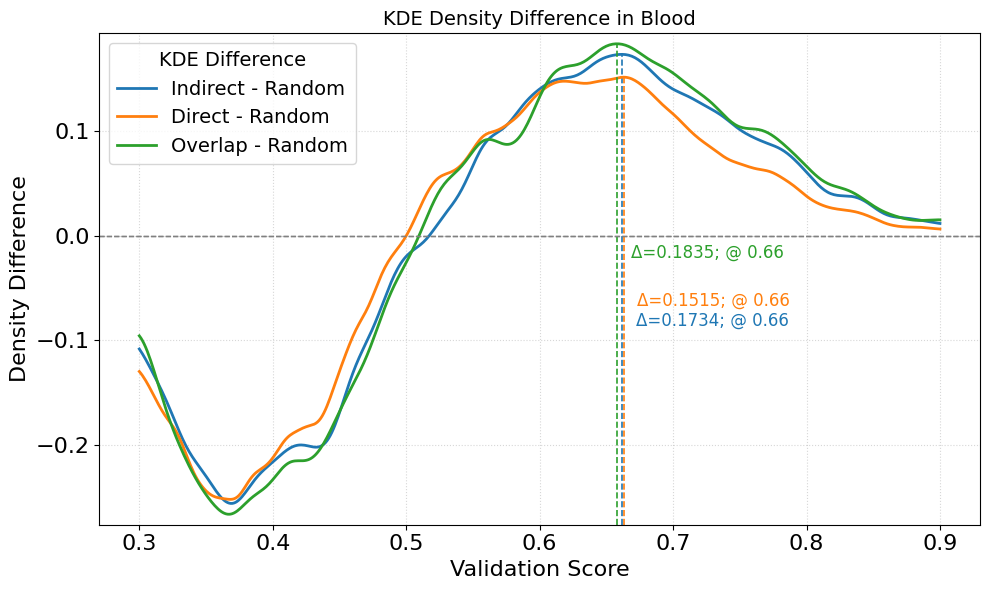

In [11]:
#KDE curve
valid_ppi_ex_df = valid_ppi_df
valid_ppi_dict = valid_ppi_dict_t

degree_df = pd.concat([valid_ppi_ex_df[['prot1']], valid_ppi_ex_df[['prot2']].rename(columns={'prot2': 'prot1'})])
degree_count = degree_df['prot1'].value_counts().to_dict()
valid_proteins = set(degree_count.keys())

def extract_scores(pairs):
    return [valid_ppi_dict[pair] for pair in pairs if pair in valid_ppi_dict]

scores = {
    'Direct': extract_scores(only_direct),
    'Indirect': extract_scores(only_indirect),
    'Overlap': extract_scores(overlap_pairs),
}

def compute_pair_degrees(pairs):
    degrees = []
    for pair in pairs:
        a, b = list(pair)
        d1 = degree_count.get(a, 0)
        d2 = degree_count.get(b, 0)
        degrees.append((d1 + d2) / 2)
    return np.array(degrees)

target_degrees = compute_pair_degrees(only_indirect)
bins = pd.qcut(target_degrees, q=10, duplicates='drop')
bin_counts = bins.value_counts().to_dict()

# Create pool of all possible pairs from valid_proteins
all_proteins = list(valid_proteins)
random_pool = set()
while len(random_pool) < len(overlap_pairs) * 3:  # oversample for stratification
    p1, p2 = random.sample(all_proteins, 2)
    random_pool.add(frozenset([p1, p2]))

# Bucket candidate pairs by degree
random_buckets = defaultdict(list)
for pair in random_pool:
    a, b = list(pair)
    deg = (degree_count.get(a, 0) + degree_count.get(b, 0)) / 2
    for label in bin_counts:
        if label.left <= deg < label.right:
            random_buckets[label].append(pair)
            break

# Stratified sampling
matched_random_pairs = set()
for label, count in bin_counts.items():
    candidates = random_buckets.get(label, [])
    if len(candidates) >= count:
        sampled = random.sample(candidates, count)
        matched_random_pairs.update(sampled)

# Final random scores
scores['Random'] = extract_scores(matched_random_pairs)

comparisons = [('Indirect', 'Random'), ('Direct', 'Random'), ('Overlap', 'Random')]
stat_rows = []
for g1, g2 in comparisons:
    t_stat, t_p = ttest_ind(scores[g1], scores[g2], equal_var=False)
    ks_stat, ks_p = ks_2samp(scores[g1], scores[g2])
    mw_stat, mw_p = mannwhitneyu(scores[g1], scores[g2], alternative='two-sided')
    mean_g1 = np.mean(scores[g1])
    mean_g2 = np.mean(scores[g2])
    delta = mean_g1 - mean_g2
    stat_rows.append({
        'Comparison': f'{g1} vs {g2}',
        'Δ Mean': round(delta, 5),
        'T-test p': t_p,
        'KS-test p': ks_p,
        'MW U-test p': mw_p,
    })
stats_df = pd.DataFrame(stat_rows)

conf_stats = []
for g, sc in scores.items():
    total = len(sc)
    high = np.sum(np.array(sc) >= 0.6)
    very_high = np.sum(np.array(sc) >= 0.7)
    super_high = np.sum(np.array(sc) >= 0.8)
    conf_stats.append({
        'Group': g,
        'Total': total,
        '>0.6 (%)': round(high / total * 100, 2),
        '>0.7 (%)': round(very_high / total * 100, 2),
        '>0.8 (%)': round(super_high / total * 100, 2)
    })
conf_df = pd.DataFrame(conf_stats)

x_grid = np.linspace(0.3, 0.9, 500)
kde_curves = {}
groups = ['Indirect', 'Direct', 'Overlap', 'Random']
colors = {
    'Indirect - Random': '#1f77b4',
    'Direct - Random': '#ff7f0e',
    'Overlap - Random': '#2ca02c'
}

kde_dict = {g: gaussian_kde(scores[g])(x_grid) for g in groups}
diff_curves = {
    'Indirect - Random': kde_dict['Indirect'] - kde_dict['Random'],
    'Direct - Random': kde_dict['Direct'] - kde_dict['Random'],
    'Overlap - Random': kde_dict['Overlap'] - kde_dict['Random'],
}

plt.figure(figsize=(10, 6))
all_diff_vals = np.concatenate(list(diff_curves.values()))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.ylim(all_diff_vals.min() - 0.01, all_diff_vals.max() + 0.01)

text_offsets = [-0.03, 0, 0.03]  # vertical offset to avoid overlapping text
i = 0
for label, diff in diff_curves.items():
    color = colors[label]
    plt.plot(x_grid, diff, label=label, color=color, linewidth=2)

    max_diff = np.max(diff)
    x_max = x_grid[np.argmax(diff)]
    y_min = min(0, all_diff_vals.min()) - 0.01  # ensure vline extends to x-axis

    # Draw vertical line from x-axis up to curve peak
    plt.vlines(x=x_max, ymin=y_min, ymax=max_diff, color=color, linestyle='--', linewidth=1.2)

    # Place text label to the side of the line at mid-height
    y_label = (max_diff + y_min) / 2 + text_offsets[i % len(text_offsets)]
    plt.text(x_max + 0.01, y_label,
             f'Δ={max_diff:.4f}; @ {x_max:.2f}',
             color=color, fontsize=12, ha='left', va='center')
    i += 1

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('KDE Density Difference in Blood', fontsize=14)
plt.xlabel('Validation Score', fontsize=16)
plt.ylabel('Density Difference', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='KDE Difference', title_fontsize=14, fontsize=14)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
#plt.savefig("../results/model_2/KDE_Density_Difference_blood.png", dpi=500)

In [ ]:
#Topological proximity
def compute_graph_metrics(G, pairs):
    node_set = set()
    for pair in pairs:
        node_set.update(pair)
    subgraph = G.subgraph(node_set).copy()

    metrics = {
        'n_nodes': subgraph.number_of_nodes(),
        'n_edges': subgraph.number_of_edges(),
        'density': nx.density(subgraph),
        'avg_clustering': nx.average_clustering(subgraph),
        'n_components': nx.number_connected_components(subgraph),
    }

    if nx.is_connected(subgraph):
        metrics['avg_path_len'] = nx.average_shortest_path_length(subgraph)
    else:
        metrics['avg_path_len'] = np.nan

    return metrics

def compute_advanced_metrics(G, pair_sets):
    advanced_metrics = []
    for label, pairs in pair_sets.items():
        node_set = set()
        for pair in pairs:
            node_set.update(pair)
        subgraph = G.subgraph(node_set).copy()

        try:
            communities = list(greedy_modularity_communities(subgraph))
            modularity = nx.algorithms.community.quality.modularity(subgraph, communities)
        except Exception:
            modularity = np.nan

        try:
            transitivity = nx.transitivity(subgraph)
        except:
            transitivity = np.nan

        try:
            assortativity = nx.degree_assortativity_coefficient(subgraph)
        except:
            assortativity = np.nan

        try:
            core_nums = nx.core_number(subgraph)
            max_kcore_size = sum(1 for v in core_nums.values() if v >= 3)
        except:
            max_kcore_size = np.nan

        advanced_metrics.append({
            'Group': label,
            'modularity': modularity,
            'transitivity': transitivity,
            'assortativity': assortativity,
            'kcore_3plus_size': max_kcore_size
        })

    return pd.DataFrame(advanced_metrics)

ppi_cutoff = 0.5
valid_ppi_df_filtered = lung_valid_ppi_df[lung_valid_ppi_df['lung'] >= ppi_cutoff]

G_ppi = nx.Graph()
G_ppi.add_edges_from(zip(valid_ppi_df_filtered['prot1'], valid_ppi_df_filtered['prot2']))

pair_sets = {
    'Direct': only_direct,
    'Indirect': only_indirect,
    'Overlap': overlap_pairs,
    'Random': matched_random_pairs
}

results = []
for group, pair_set in pair_sets.items():
    m = compute_graph_metrics(G_ppi, pair_set)
    m['Group'] = group
    results.append(m)

structure_df = pd.DataFrame(results)   
advanced_df = compute_advanced_metrics(G_ppi, pair_sets)
enhanced_structure_df = structure_df.merge(advanced_df, on="Group", how="left")
#enhanced_structure_df.to_csv('../results/model_2/validation_enhanced_structure.csv', index=None)

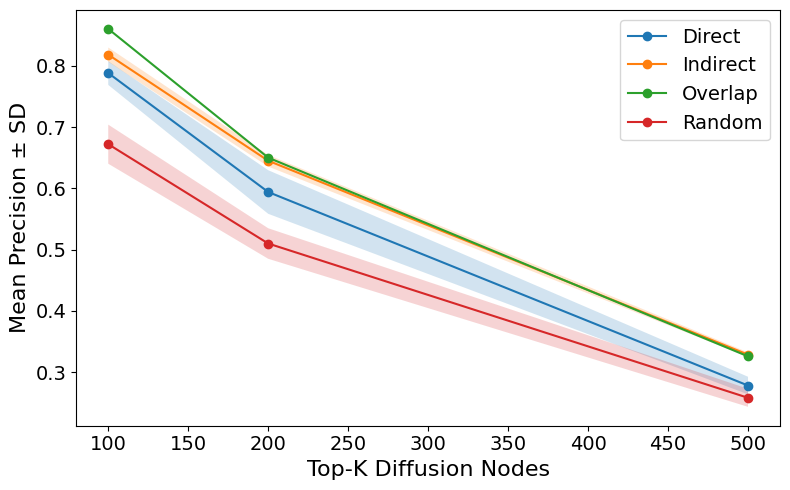

In [14]:
#Network propagation
ppi_cutoff = 0.8
valid_ppi_df_filtered = valid_ppi_df[valid_ppi_df['blood'] >= ppi_cutoff]
G_ppi = nx.Graph()
G_ppi.add_edges_from(zip(valid_ppi_df_filtered['prot1'], valid_ppi_df_filtered['prot2']))

degree_dict = dict(G_ppi.degree())
top_k = 500
target_set = set(sorted(degree_dict, key=degree_dict.get, reverse=True)[:top_k])

group_seeds = {
    'Direct': {p for pair in only_direct for p in pair},
    'Indirect': {p for pair in only_indirect for p in pair},
    'Overlap': {p for pair in overlap_pairs for p in pair}
}


seed_sizes = {k: len(v) for k, v in group_seeds.items()}
min_size = min(seed_sizes.values())


random_nodes = set()
for pair in matched_random_pairs:
    random_nodes.update(pair)
random_nodes = list(random_nodes)

def run_rwr(G, seed_nodes, restart_prob=0.7, max_iter=100, tol=1e-6):
    nodes = list(G.nodes())
    node_idx = {n: i for i, n in enumerate(nodes)}
    idx_node = {i: n for n, i in node_idx.items()}
    N = len(nodes)

    A = nx.to_scipy_sparse_array(G, nodelist=nodes, dtype=float)
    degrees = np.array(A.sum(axis=1)).flatten()
    D_inv = np.diag(1 / degrees)
    P = D_inv @ A

    r = np.zeros(N)
    for s in seed_nodes:
        if s in node_idx:
            r[node_idx[s]] = 1.0
    r = r / r.sum()

    p = r.copy()
    for _ in range(max_iter):
        p_new = (1 - restart_prob) * P.T @ p + restart_prob * r
        if np.linalg.norm(p_new - p, 1) < tol:
            break
        p = p_new

    return {idx_node[i]: p[i] for i in range(N)}

def evaluate_spread(scores, target_set, top_k_list=[100, 200, 500]):
    ranked_nodes = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    result = []
    for k in top_k_list:
        top_k_nodes = {n for n, _ in ranked_nodes[:k]}
        hits = len(top_k_nodes & target_set)
        result.append((k, hits / k))  # (Top-K, Precision)
    return result


def multi_run_eval(G, group_seeds, target_set, random_nodes, n_repeat=5, top_k_list=[100, 200, 500]):
    group_precision = defaultdict(lambda: defaultdict(list))  # Group -> Top-K -> [values]

    for _ in range(n_repeat):
        for group, full_seeds in group_seeds.items():
            sampled_seeds = random.sample(list(full_seeds), min_size)
            scores = run_rwr(G, sampled_seeds)
            result = evaluate_spread(scores, target_set, top_k_list)
            for k, prec in result:
                group_precision[group][k].append(prec)

        rand_seeds = random.sample(random_nodes, min_size)
        scores = run_rwr(G, rand_seeds)
        result = evaluate_spread(scores, target_set, top_k_list)
        for k, prec in result:
            group_precision['Random'][k].append(prec)

    return group_precision


group_precision = multi_run_eval(G_ppi, group_seeds, target_set, random_nodes, n_repeat=5)

records = []
for group, k_dict in group_precision.items():
    for k, vals in k_dict.items():
        records.append({
            'Group': group,
            'Top-K': k,
            'Precision Mean': np.mean(vals),
            'Precision Std': np.std(vals)
        })
diffusion_eval_df = pd.DataFrame(records)

plt.figure(figsize=(8, 5))
for group in diffusion_eval_df['Group'].unique():
    sub = diffusion_eval_df[diffusion_eval_df['Group'] == group]
    plt.plot(sub['Top-K'], sub['Precision Mean'], marker='o', label=group)
    plt.fill_between(sub['Top-K'], sub['Precision Mean'] - sub['Precision Std'],
                     sub['Precision Mean'] + sub['Precision Std'], alpha=0.2)
#plt.title("Normalized Precision@K in Blood")
plt.xlabel("Top-K Diffusion Nodes",fontsize=16)
plt.ylabel("Mean Precision ± SD",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig("../results/model_2/normalized_diffusion_precision_blood.png", dpi=500)


In [16]:
#Case
blood_original_df = pd.read_csv('../results/tissue_type/blood_edges.csv', sep=',')
blood_prediction_df = pd.read_csv('../results/tissue_type/blood_prediction.csv', sep=',')
blood_indirect_df = pd.read_csv('../results/model_2/blood_predictions.csv')
blood_top15000_df = blood_prediction_df.sort_values(by='pred_score', ascending=False).head(15000)
specific_validation_df = pd.read_csv('../data/validation_tissue/specific_validation.csv')

meta_type_df = pd.read_csv('../data/validation_tissue/metatype.csv')
meta_type_df = meta_type_df[meta_type_df['m.hmdb_id'] != '']
meta_type_dict = meta_type_df.set_index('m.hmdb_id').to_dict()['m.refmet_SuperClass']
lipids = ['Fatty Acyls', 'Glycerophospholipids', 'Sphingolipids', 'Glycerolipids', 'Sterol Lipids', 'Prenol Lipids']
meta_type_dict = {k:'Lipids' if v in lipids else v for k,v in meta_type_dict.items()}

def edge_status(m, p):
    if (m, p) in orignal_pairs:
        return 'Original'
    elif (m, p) in extand_max_pairs:
        return 'New'
    elif (m,p) in indirect_pairs:
        return 'Indirect'
    else:
        return 'Not Found'
orignal_pairs = set(zip(blood_original_df[blood_original_df['edge_type'] == 'PMI']['node1'], blood_original_df[blood_original_df['edge_type'] == 'PMI']['node2']))
extand_pairs = set(zip(blood_top15000_df['metabolite'], blood_top15000_df['protein']))
blood_prediction_ex_df = blood_prediction_df[blood_prediction_df['pred_score'] >= 0.8]
extand_max_pairs = set(zip(blood_prediction_ex_df['metabolite'], blood_prediction_ex_df['protein']))
blood_indirect_ex_df = blood_indirect_df[blood_indirect_df['pred_score'] >= 0.8]
indirect_pairs = set(zip(blood_indirect_ex_df['metabolite'], blood_indirect_ex_df['protein']))
liqid_m_list = [k for k, v in meta_type_dict.items() if v == 'Lipids']
nucl_m_list =  [k for k, v in meta_type_dict.items() if v == 'Nucleic acids']
organ_m_list = [k for k, v in meta_type_dict.items() if v == 'Organic acids']

In [17]:
liqid_df = specific_validation_df.copy()
liqid_df = liqid_df[liqid_df['metabolite_name'] == 'liqid']
liqid_df['metabolite_id'] = ','.join(liqid_m_list)
liqid_df = liqid_df.assign(protein_id  = liqid_df['protein_id'].str.split(',')).explode('protein_id').assign(metabolite_id = liqid_df['metabolite_id'].str.split(',')).explode('metabolite_id')
liqid_df['protein_id']   = liqid_df['protein_id'].str.strip()
liqid_df['metabolite_id'] = liqid_df['metabolite_id'].str.strip()
liqid_df['edge_status'] = liqid_df.apply(lambda x: edge_status(x['metabolite_id'], x['protein_id']), axis=1)
liqid_df = liqid_df[liqid_df['edge_status'] != 'Not Found'].reset_index(drop=True)
liqid_df = liqid_df.rename(columns={'metabolite_name':'metabolite_type'})
liqid_df['metabolite_name'] = liqid_df['metabolite_id'].apply(lambda x:hmdb_name_dict[x])
liqid_df['protein_name'] = liqid_df['protein_name'].apply(lambda x:'PCSK9' if x == 'Proprotein convertase subtilisin/kexin type 9' else x)

nucl_df = specific_validation_df.copy()
nucl_df = nucl_df[nucl_df['metabolite_name'] == 'nucleic acids']
nucl_df['metabolite_id'] = ','.join(liqid_m_list)
nucl_df = nucl_df.assign(protein_id   = nucl_df['protein_id'].str.split(',')).explode('protein_id').assign(metabolite_id = nucl_df['metabolite_id'].str.split(',')).explode('metabolite_id')
nucl_df['protein_id']   = nucl_df['protein_id'].str.strip()
nucl_df['metabolite_id'] = nucl_df['metabolite_id'].str.strip()
nucl_df['edge_status'] = nucl_df.apply(lambda x: edge_status(x['metabolite_id'], x['protein_id']), axis=1)
nucl_df = nucl_df[nucl_df['edge_status'] != 'Not Found'].reset_index(drop=True)
nucl_df = nucl_df.rename(columns={'metabolite_name':'metabolite_type'})
nucl_df['metabolite_name'] = nucl_df['metabolite_id'].apply(lambda x:hmdb_name_dict[x])

other_df = specific_validation_df.copy()
other_df = other_df.assign(protein_id   = other_df['protein_id'].str.split(',')).explode('protein_id').assign(metabolite_id = other_df['metabolite_id'].str.split(',')).explode('metabolite_id')
other_df['protein_id']   = other_df['protein_id'].str.strip()
other_df['metabolite_id'] = other_df['metabolite_id'].str.strip()
other_df['edge_status'] = other_df.apply(lambda x: edge_status(x['metabolite_id'], x['protein_id']), axis=1)
other_df = other_df[other_df['edge_status'] != 'Not Found'].reset_index(drop=True)
other_df['metabolite_type'] = other_df['metabolite_id'].apply(lambda x:meta_type_dict[x])

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import matplotlib.patches as mpatches


def visualize_verified_pmi_bipartite(liqid_df, title):
    # Build graph
    G = nx.Graph()
    for _, row in liqid_df.iterrows():
        p = row['protein_name']
        m = row['metabolite_name']
        status = row['edge_status']
        G.add_node(p, type='protein')
        G.add_node(m, type='metabolite')
        G.add_edge(m, p, status=status)

    # Classify nodes
    proteins = [n for n, d in G.nodes(data=True) if d['type'] == 'protein']
    metabolites = [n for n, d in G.nodes(data=True) if d['type'] == 'metabolite']

    # Build edge groups
    edge_groups = defaultdict(list)
    for u, v, d in G.edges(data=True):
        status = d['status']
        edge_groups[status].append((u, v))

    # Sort nodes by connection count and edge type (prioritize 'New' on top)
    def sort_by_priority(nodes, edge_type_priority):
        count = defaultdict(int)
        for status in edge_type_priority:
            for u, v in edge_groups[status]:
                if u in nodes:
                    count[u] += 10 if status == 'New' else 1
                if v in nodes:
                    count[v] += 10 if status == 'New' else 1
        return sorted(nodes, key=lambda n: -count[n])

    proteins_sorted = sort_by_priority(proteins, ['New', 'Indirect'])
    metabolites_sorted = sort_by_priority(metabolites, ['New', 'Indirect'])
    num_proteins = len(proteins_sorted)
    num_metabolites = len(metabolites_sorted)
    height = max(num_proteins, num_metabolites)

    # Layout
    pos = {}
    for i, node in enumerate(proteins_sorted):
        y = height - (i + 1) * height / (num_proteins + 1)
        pos[node] = (0, y)
    for i, node in enumerate(metabolites_sorted):
        y = height - (i + 1) * height / (num_metabolites + 1)
        pos[node] = (1, y)

    fig, ax = plt.subplots(figsize=(10, 6))

    # 更专业的颜色（来自 ColorBrewer & Nature 风格）
    color_protein = "#3E4A89"     # navy blue
    color_metabolite = "#6BA292"  # muted teal
    color_direct = "#36454F"      # dark slate blue-gray
    color_indirect = "#A63D40"
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=proteins_sorted, node_color=color_protein, node_shape='o',
                        node_size=80, label='Protein', ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=metabolites_sorted, node_color=color_metabolite, node_shape='s',
                        node_size=80, label='Metabolite', ax=ax)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=edge_groups['New'], edge_color=color_direct,
                        width=2, alpha=0.7, label='Direct prediction', ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=edge_groups['Indirect'], edge_color=color_indirect,
                        width=2, alpha=0.7, label='Indirect prediction', ax=ax)

    # Add node labels
    for n in G.nodes():
        x, y = pos[n]
        ha = 'right' if x == 0 else 'left'
        offset = -0.05 if x == 0 else 0.05
        ax.text(x + offset, y, n, fontsize=12, ha=ha, va='center', clip_on=False, color='black')

    # Title
    #ax.set_title(f'Validated Protein–Metabolite Interactions in {title}', fontsize=14, pad=10)

    # Legend with custom markers
    legend_elements = [
        mpatches.Patch(color=color_protein, label='Protein', alpha=0.9),
        mpatches.Patch(color=color_metabolite, label='Metabolite', alpha=0.9),
        mpatches.Patch(color=color_direct, label='Direct prediction', alpha=0.9),
        mpatches.Patch(color=color_indirect, label='Indirect prediction', alpha=0.9)
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=10, frameon=False)

    # Clean layout
    ax.set_axis_off()
    ax.set_xlim(-0.6, 1.6)
    plt.tight_layout()

    # Save figure
    #plt.savefig(f"{out_dir}Validation_{title}.png", dpi=500, bbox_inches='tight')
    plt.show()

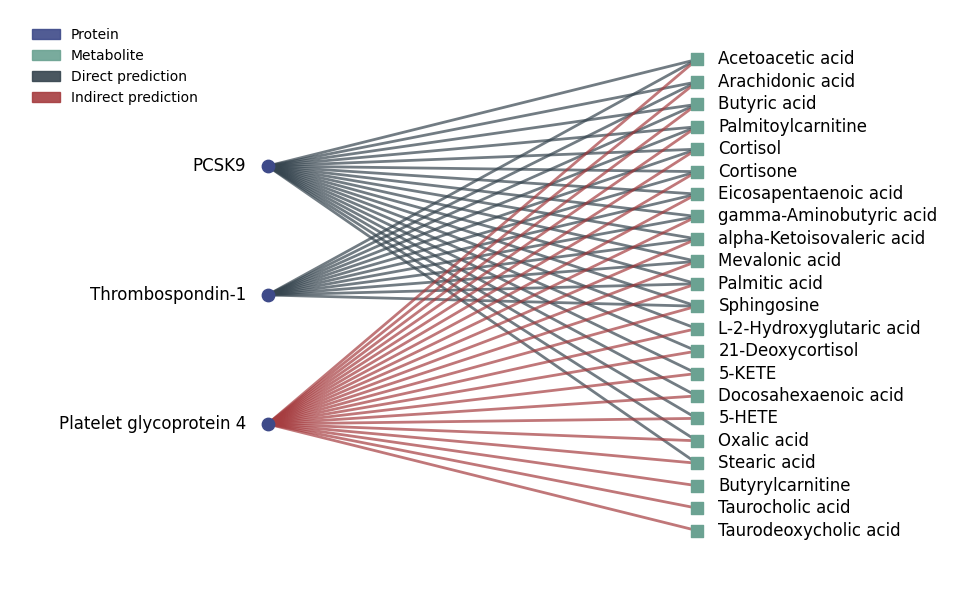

In [19]:
visualize_verified_pmi_bipartite(liqid_df, "Lipid")

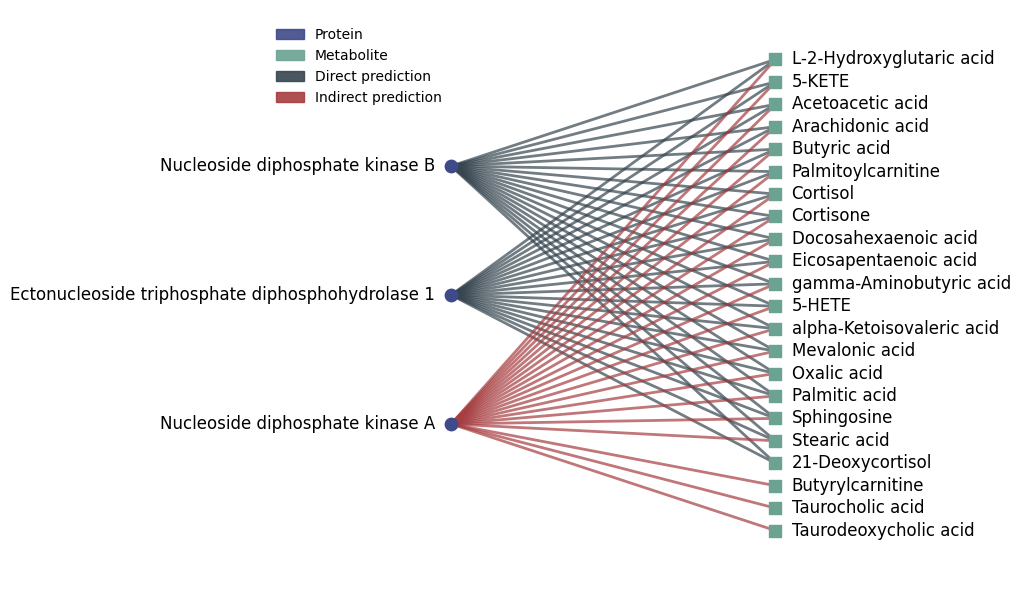

In [20]:
visualize_verified_pmi_bipartite(nucl_df, "Nucleic Acids")

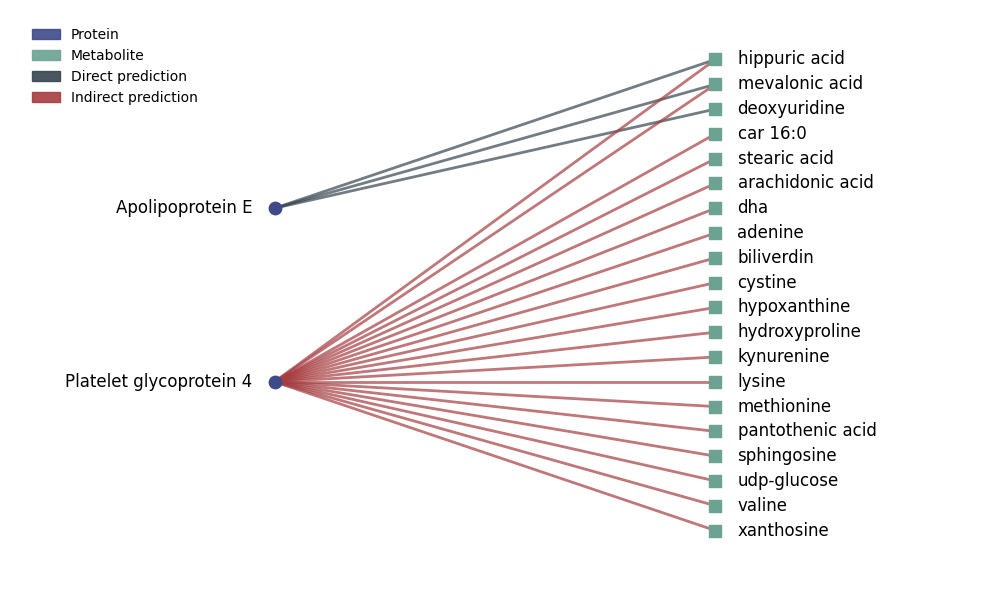

In [21]:
visualize_verified_pmi_bipartite(other_df, "APoE and CD36")